In [1]:
# diffusion schedule
import math
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# 1. exponential  schedule (c,rho)
def exponential_schedule(N=4, c =.1, rho=1.5):
    n = np.arange(1, N+1 ) #n=1,..,N
    gamma = c * (rho ** (n - 1))
    alpha = np.exp(-2.0 * gamma)
    bar_alpha = np.cumprod(alpha)
    snr = bar_alpha / (1.0 - bar_alpha)
    return n, gamma, bar_alpha, snr

# 2. Cosine beta schedule
# ref.  (Nichol-Dhariwal 2021) "Improved Denoising Diffusion Probabilistic Models"
# https://proceedings.mlr.press/v139/nichol21a.html, sec 3.2
# s is cosine offset, default value s=0.008
def cosine_schedule(N=4, s=0.008): 
    def cosine_bar_alpha(n, N, s=0.008):
        return np.cos(((n / N + s) / (1 + s)) * math.pi / 2) ** 2
    
    n = np.arange(1, N+1 ) #n=1,..,N
    bar_alpha = np.array([
        cosine_bar_alpha(k, N, s) / cosine_bar_alpha(0, N, s)
        for k in range(0, N + 1)
    ])
    beta = 1.0 - bar_alpha[1:] / bar_alpha[:-1]
    beta = np.clip(beta, 0.0, 0.999)
    alpha = 1.0 - beta
    bar_alpha = np.cumprod(alpha)
    snr = bar_alpha / (1.0 - bar_alpha)
    gamma = np.log(alpha)/(-2.0)
    return n, gamma, bar_alpha, snr


# 3. Linear beta schedule
def linear_schedule(N = 4, beta_min = 0.1, beta_max = np.min([4*0.99, 20])):
    n = np.arange(1, N+1 ) #n=1,..,N
    beta = np.linspace(beta_min/N, beta_max/N, N)
    alpha = 1.0 - beta
    bar_alpha = np.cumprod(alpha)
    snr = bar_alpha / (1.0 - bar_alpha)
    gamma = np.log(alpha)/(-2.0)
    return n, gamma, bar_alpha, snr

In [12]:
# -----------------------------
# print for the schedule to be used in code
# -----------------------------

# we truncate the last one to be none, because we use free block to connect to N(0,I) in the last block

print(f"\n----- exponential schedule -----")
c = .1
rho = 1.5
print(f"c={c:.6f}, rho={rho:.6f}")
for N in range(2, 10):
    _, gamma, _, _ = exponential_schedule(N, c , rho)
    hks = [round(float(g), 6) for g in gamma[:-1]] + [None]
    print(f"N = {N}, hks = {hks}\n")

print(f"\n----- diffusion cosine schedule -----")
s = 0.008
print(f"s={s:.6f}")
for N in range(2, 10):
    _, gamma, _, _ = cosine_schedule(N, s= 0.008)
    hks = [round(float(g), 6) for g in gamma[:-1]] + [None]
    print(f"N = {N}, hks = {hks}\n")

print(f"\n----- diffusion linear schedule -----")   
for N in range(2, 10):
    beta_min = 0.1
    beta_max = np.min([N*0.99, 20])
    print(f"beta_min = {beta_min:.6f}, beta_max = {beta_max:.6f}")
    _, gamma, _, _ = linear_schedule(N, beta_min, beta_max)
    hks = [round(float(g), 6) for g in gamma[:-1]] + [None]
    print(f"N = {N}, hks = {hks}\n")


----- exponential schedule -----
c=0.100000, rho=1.500000
N = 2, hks = [0.1, None]

N = 3, hks = [0.1, 0.15, None]

N = 4, hks = [0.1, 0.15, 0.225, None]

N = 5, hks = [0.1, 0.15, 0.225, 0.3375, None]

N = 6, hks = [0.1, 0.15, 0.225, 0.3375, 0.50625, None]

N = 7, hks = [0.1, 0.15, 0.225, 0.3375, 0.50625, 0.759375, None]

N = 8, hks = [0.1, 0.15, 0.225, 0.3375, 0.50625, 0.759375, 1.139063, None]

N = 9, hks = [0.1, 0.15, 0.225, 0.3375, 0.50625, 0.759375, 1.139063, 1.708594, None]


----- diffusion cosine schedule -----
s=0.008000
N = 2, hks = [0.352768, None]

N = 3, hks = [0.148608, 0.551694, None]

N = 4, hks = [0.08302, 0.269748, 0.615259, None]

N = 5, hks = [0.0534, 0.163935, 0.320881, 0.643772, None]

N = 6, hks = [0.037432, 0.111176, 0.20416, 0.347534, 0.659033, None]

N = 7, hks = [0.027813, 0.080731, 0.143217, 0.227321, 0.363249, 0.66816, None]

N = 8, hks = [0.021556, 0.061464, 0.106713, 0.163035, 0.241947, 0.373312, 0.674054, None]

N = 9, hks = [0.017248, 0.048459, 0.08290

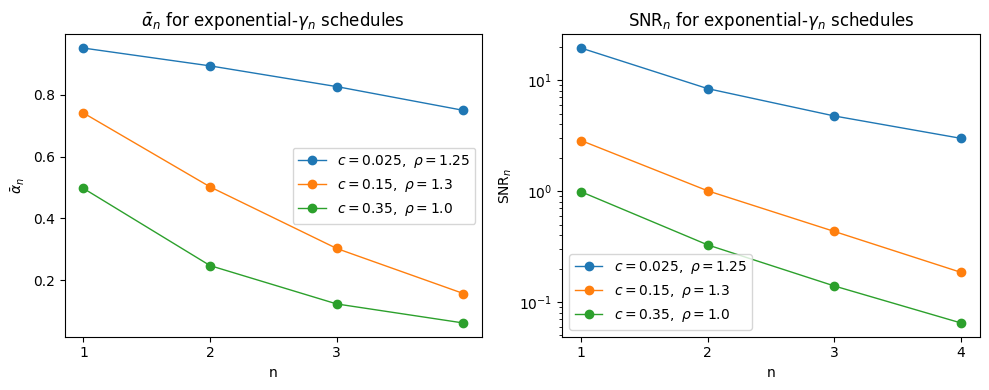

In [13]:
# ------------------------------
# visualization of different schedules
# ------------------------------

# Parameters
N = 4
configs = [
    (0.025, 1.25),
    (0.15, 1.3),
    (0.35, 1.0),
]
# Plot bar{alpha}_n
plt.figure(figsize=(10, 4))
plt.subplot(121)
for c, rho in configs:
    n, gamma, bar_alpha, snr = exponential_schedule(N, c, rho)
    plt.plot(
        n, bar_alpha,
        marker='o', linewidth=1,
        label=fr"$c={c},\ \rho={rho}$"
    )

plt.xlabel("n")
plt.ylabel(r"$\bar{\alpha}_n$")
plt.title(r"$\bar{\alpha}_n$ for exponential-$\gamma_n$ schedules")
plt.xticks(np.arange(1, N ))
plt.legend()
plt.tight_layout()
plt.subplot(122)
for c, rho in configs:
    n, gamma, bar_alpha, snr = exponential_schedule(N, c, rho)
    plt.plot(
        n, snr,
        marker='o', linewidth=1,
        label=fr"$c={c},\ \rho={rho}$"
    )

plt.yscale("log")
plt.xlabel("n")
plt.ylabel(r"SNR$_n$")
plt.title(r"SNR$_n$ for exponential-$\gamma_n$ schedules")
plt.xticks(np.arange(1, N + 1))
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
c = 0.3
rho = 1.1
n, gamma_exp, bar_alpha_exp, snr_exp = exponential_schedule(N, c, rho)
print(gamma_exp)

[0.3    0.33   0.363  0.3993]


In [15]:
n, gamma_cos, bar_alpha_cos, snr_cos = cosine_schedule(N, s)
print(gamma_cos)

[0.08302011 0.2697481  0.61525887 3.45387764]


In [16]:
beta_min = 0.1
beta_max = np.min([N*0.99, 20])
n, gamma_lin, bar_alpha_lin, snr_lin = linear_schedule(N, beta_min, beta_max)
print(gamma_lin)

[0.0126589  0.21283391 0.55181242 2.30258509]


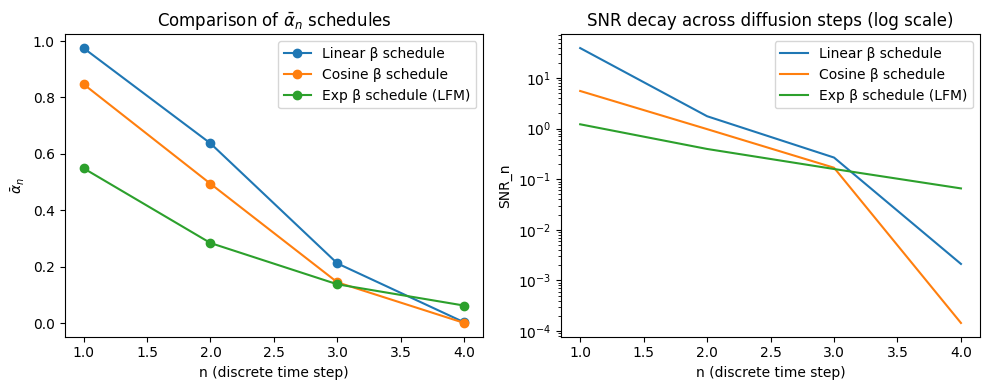

In [17]:
# -----------------------------
# Plot bar{alpha}_n vs n
# -----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(n, bar_alpha_lin, marker='o', label="Linear β schedule")
plt.plot(n, bar_alpha_cos, marker='o', label="Cosine β schedule")
plt.plot(n, bar_alpha_exp, marker='o', label="Exp β schedule (LFM)")
plt.xlabel("n (discrete time step)")
plt.ylabel(r"$\bar{\alpha}_n$")
plt.title(r"Comparison of $\bar{\alpha}_n$ schedules")
plt.legend()
plt.tight_layout()
plt.subplot(122)
plt.plot(n, snr_lin, label="Linear β schedule")
plt.plot(n, snr_cos, label="Cosine β schedule")
plt.plot(n, snr_exp, label="Exp β schedule (LFM)")
plt.yscale("log")
plt.xlabel("n (discrete time step)")
plt.ylabel("SNR_n")
plt.title("SNR decay across diffusion steps (log scale)")
plt.legend()
plt.tight_layout()
plt.show()